In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [7]:
# Load dataset
df = pd.read_csv(r"C:\Users\bhuve\OneDrive\Documents\retail_stores_inventory.csv")

# Convert Date
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Sort by Product & Date
df = df.sort_values(by=["Product ID", "Date"])


In [8]:
# Lag features
df["Sales_Lag_7"] = df.groupby("Product ID")["Units Sold"].shift(7)
df["Sales_Lag_30"] = df.groupby("Product ID")["Units Sold"].shift(30)

# Rolling mean
df["Rolling_Mean_7"] = (
    df.groupby("Product ID")["Units Sold"]
      .transform(lambda x: x.rolling(7).mean())
)


In [9]:
le = LabelEncoder()

for col in [
    "Store ID", "Product ID", "Category",
    "Region", "Weather Condition", "Seasonality"
]:
    df[col] = le.fit_transform(df[col])




In [10]:
df = df.dropna()


In [11]:
X = df[
    [
        "Store ID",
        "Product ID",
        "Category",
        "Region",
        "Price",
        "Discount",
        "Weather Condition",
        "Holiday/Promotion",
        "Seasonality",
        "Sales_Lag_7",
        "Sales_Lag_30",
        "Rolling_Mean_7",
    ]
]

y = df["Units Sold"]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [13]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [14]:

y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train R²:", r2_score(y_train, model.predict(X_train)))
print("Test R² :", r2_score(y_test, y_pred))


MAE : 83.1455757518304
RMSE: 102.19450026193826
Train R²: 0.7370914287401658
Test R² : 0.12190688900556068


In [15]:
results = X_test.copy()

results["Actual_Demand"] = y_test.values
results["Predicted_Demand"] = y_pred
results["Error"] = results["Actual_Demand"] - results["Predicted_Demand"]

print(results.head())




     Store ID  Product ID  Category  Region  Price  Discount  \
616         0          16         2       2  13.81         0   
636         1          16         1       2  79.73         0   
656         2          16         0       1  34.38        20   
676         3          16         2       2  94.56        10   
696         4          16         3       0  78.41        10   

     Weather Condition  Holiday/Promotion  Seasonality  Sales_Lag_7  \
616                  2                  1            1         75.0   
636                  1                  1            3         15.0   
656                  2                  1            3         26.0   
676                  1                  1            2         57.0   
696                  2                  1            0        162.0   

     Sales_Lag_30  Rolling_Mean_7  Actual_Demand  Predicted_Demand       Error  
616         246.0      109.714286             66        123.871008  -57.871008  
636         373.0      121

In [16]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 102.19450026193826


In [17]:
inventory = results.copy()

# Safety stock
safety_stock = 1.65 * rmse

# Lead time (days)
lead_time = 3

# Reorder Point
inventory["Reorder_Point"] = (
    inventory["Predicted_Demand"] * lead_time
) + safety_stock

# Suggested Order Quantity
inventory["Suggested_Order"] = inventory["Reorder_Point"].round().astype(int)


In [18]:
inventory["Stock_Status"] = np.where(
    inventory["Predicted_Demand"] > inventory["Sales_Lag_7"],
    "Increase Stock",
    "Maintain / Reduce"
)


In [19]:
final_inventory = inventory[
    [
        "Store ID",
        "Product ID",
        "Category",
        "Actual_Demand",
        "Predicted_Demand",
        "Reorder_Point",
        "Suggested_Order",
        "Stock_Status"
    ]
]

print(final_inventory.head(10))


     Store ID  Product ID  Category  Actual_Demand  Predicted_Demand  \
616         0          16         2             66        123.871008   
636         1          16         1            100        142.948400   
656         2          16         0             12        124.431471   
676         3          16         2              4        118.849908   
696         4          16         3            186        119.220620   
716         0          16         0            248        127.679239   
736         1          16         3            153        114.957926   
756         2          16         1             85        131.139714   
776         3          16         4            105        100.692983   
796         4          16         0            116        153.345734   

     Reorder_Point  Suggested_Order       Stock_Status  
616     540.233951              540     Increase Stock  
636     597.466125              597     Increase Stock  
656     541.915338              542 

In [20]:
category_demand = inventory.groupby("Category").agg({
    "Actual_Demand": "sum",
    "Predicted_Demand": "sum"
}).reset_index()

print(category_demand)


   Category  Actual_Demand  Predicted_Demand
0         0         400931     429089.190237
1         1         395214     412223.546774
2         2         401475     420915.464972
3         3         392040     407136.558071
4         4         393199     415943.700691


In [21]:
top_products = inventory.sort_values(
    by="Predicted_Demand",
    ascending=False
).head(10)

print(top_products[[
    "Product ID",
    "Category",
    "Predicted_Demand",
    "Suggested_Order"
]])


       Product ID  Category  Predicted_Demand  Suggested_Order
5959           19         2        358.721333             1245
5999           19         4        341.082222             1192
19937          17         1        340.429603             1190
68359          19         0        326.060140             1147
63358          18         0        320.889087             1131
28036          16         4        309.796104             1098
26278          18         3        309.718056             1098
27238          18         1        308.533948             1094
19977          17         2        307.125556             1090
25019          19         0        305.598042             1085


In [22]:
region_demand = inventory.groupby("Region").agg({
    "Actual_Demand": "mean",
    "Predicted_Demand": "mean"
}).reset_index()

print(region_demand)


   Region  Actual_Demand  Predicted_Demand
0       0     137.559615        145.271103
1       1     135.835003        143.301125
2       2     138.049286        143.226059
3       3     135.582409        143.447131


In [23]:
inventory["Demand_Change"] = (
    inventory["Predicted_Demand"] - inventory["Actual_Demand"]
)

inventory["Trend"] = np.where(
    inventory["Demand_Change"] > 0,
    "Increasing",
    "Decreasing"
)

inventory[["Product ID", "Trend"]].head()


,Product ID,Trend
616,16,Increasing
636,16,Increasing
656,16,Increasing
676,16,Increasing
696,16,Decreasing


In [25]:
print(df.columns.tolist())


['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality', 'Sales_Lag_7', 'Sales_Lag_30', 'Rolling_Mean_7']


In [26]:
from sklearn.preprocessing import LabelEncoder

encode_cols = [
    'Category',
    'Region',
    'Weather Condition',
    'Seasonality',
    'Store ID',
    'Product ID'
]

label_encoders = {}

for col in encode_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le


In [27]:
features = [
    'Inventory Level',
    'Units Ordered',
    'Price',
    'Discount',
    'Competitor Pricing',
    'Holiday/Promotion',
    'Sales_Lag_7',
    'Sales_Lag_30',
    'Rolling_Mean_7',
    'Category_encoded',
    'Region_encoded',
    'Weather Condition_encoded',
    'Seasonality_encoded',
    'Store ID_encoded',
    'Product ID_encoded'
]

X = df[features]
y = df['Units Sold']


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 82.66980197177034
MAE: 64.20040344827586


In [29]:
df_test = X_test.copy()
df_test['Actual_Demand'] = y_test.values
df_test['Predicted_Demand'] = y_pred


In [30]:
lead_time = 7
z_score = 1.65

inventory_df = df_test.groupby(
    ['Store ID_encoded', 'Product ID_encoded']
).agg(
    avg_demand=('Predicted_Demand', 'mean'),
    demand_std=('Predicted_Demand', 'std'),
    current_inventory=('Inventory Level', 'mean')
).reset_index()


In [31]:
import numpy as np

inventory_df['Safety_Stock'] = (
    z_score *
    inventory_df['demand_std'] *
    np.sqrt(lead_time)
).round(0)


In [32]:
inventory_df['Reorder_Point'] = (
    inventory_df['avg_demand'] * lead_time +
    inventory_df['Safety_Stock']
).round(0)


In [33]:
def inventory_status(row):
    if row['current_inventory'] < row['Reorder_Point']:
        return 'Reorder Needed'
    elif row['current_inventory'] > row['Reorder_Point'] * 1.5:
        return 'Overstock'
    else:
        return 'Stock OK'

inventory_df['Inventory_Status'] = inventory_df.apply(
    inventory_status, axis=1
)


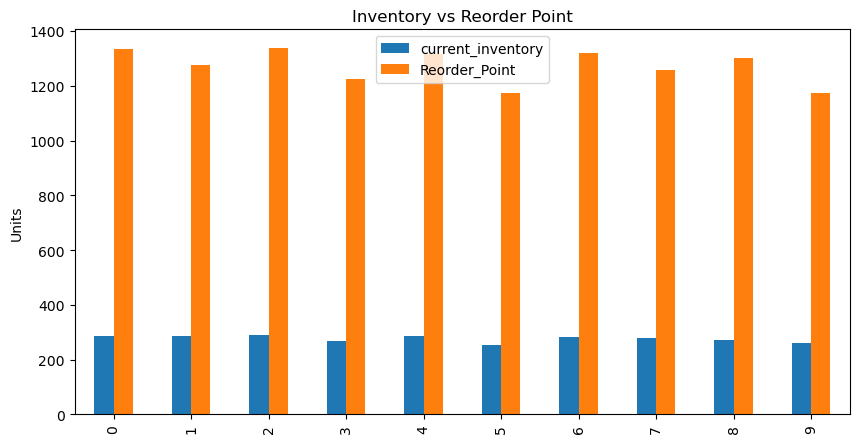

In [34]:
import matplotlib.pyplot as plt

inventory_df[['current_inventory', 'Reorder_Point']].head(10).plot(
    kind='bar',
    figsize=(10,5)
)

plt.title('Inventory vs Reorder Point')
plt.ylabel('Units')
plt.show()


In [35]:
product_demand = df.groupby('Product ID').agg(
    avg_units_sold=('Units Sold', 'mean'),
    total_units_sold=('Units Sold', 'sum')
).sort_values(by='total_units_sold', ascending=False)

product_demand.head(10)


,avg_units_sold,total_units_sold
Product ID,,
19,139.189517,504562
15,139.072828,504139
13,138.695724,502772
14,138.477241,501980
4,137.784552,499469
8,137.575448,498711
12,136.958069,496473
10,136.802483,495909
16,136.656552,495380


In [36]:
category_demand = df.groupby('Category').agg(
    total_sales=('Units Sold', 'sum'),
    avg_sales=('Units Sold', 'mean')
).sort_values(by='total_sales', ascending=False)

category_demand


,total_sales,avg_sales
Category,,
2,2010456,137.768519
0,1984563,136.696721
3,1984480,136.992959
4,1970865,135.902979
1,1944419,135.019721


In [37]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

monthly_demand = df.groupby(['Year', 'Month'])['Units Sold'].sum().reset_index()
monthly_demand.head()


,Year,Month,Units Sold
0,2022,1,339139
1,2022,2,391052
2,2022,3,426073
3,2022,4,407380
4,2022,5,414799


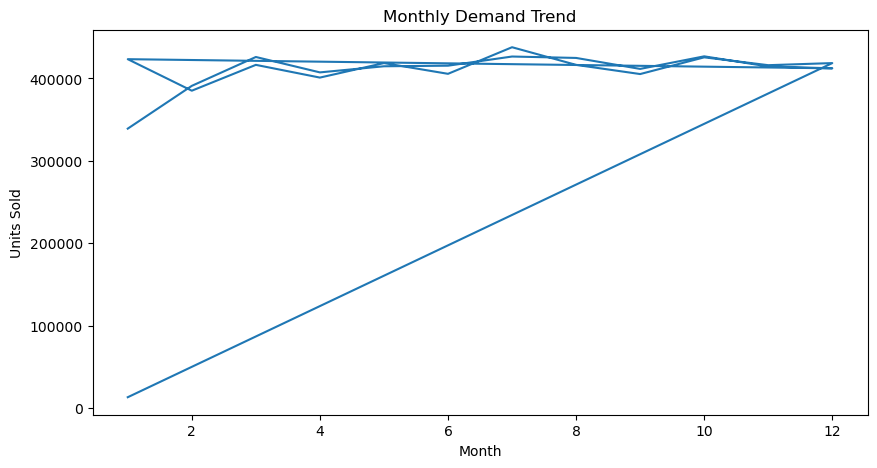

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_demand['Month'], monthly_demand['Units Sold'])
plt.title('Monthly Demand Trend')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.show()


In [39]:
season_demand = df.groupby('Seasonality')['Units Sold'].mean()

season_demand


Seasonality
0    137.786930
1    135.881562
2    135.413024
3    136.846637
Name: Units Sold, dtype: float64

In [41]:
decision_df = inventory_df[['Store ID_encoded',
                             'Product ID_encoded',
                             'Reorder_Point',
                             'current_inventory',
                             'Inventory_Status']]

decision_df.head()



,Store ID_encoded,Product ID_encoded,Reorder_Point,current_inventory,Inventory_Status
0,0,0,1333.0,286.840764,Reorder Needed
1,0,1,1276.0,285.177215,Reorder Needed
2,0,2,1339.0,288.294118,Reorder Needed
3,0,3,1225.0,266.718310,Reorder Needed
4,0,4,1315.0,284.727273,Reorder Needed
